<div class="alert alert-danger">
    <h4 style="font-weight: bold; font-size: 28px;">Baseline Models</h4>
    <p style="font-size: 20px;">NBA API Data (1984-2024)</p>
</div>

<a name="Baseline Models"></a>

# Table of Contents

[Setup](#Setup)

[Data](#Data)

[Inspect Training Windows](#Inspect-Training-Windows)

- [Expanding](#Expanding)

- [Rolling](#Rolling)

**[1. Target: Total Points (over / under)](#1.-Target:-Total-Points-(over-/-under))**

- [1.1. Expanding Window](#1.1.-Expanding-Window)

- [1.2. Rolling Window](#1.2.-Rolling-Window)

- [1.3. Experiments with Different Window Sizes](#1.3.-Experiments-with-Different-Window-Sizes)

**[2. Target: Difference in Points (plus / minus)](#2.-Target:-Difference-in-Points-(plus-/-minus))**

- [2.1. Expanding Window](#2.1.-Expanding-Window)

- [2.2. Rolling Window](#2.2.-Rolling-Window)

**[3. Target: Game Winner (moneyline)](#3.-Target:-Game-Winner-(moneyline))**

- [3.1. Expanding Window](#3.1.-Expanding-Window)

- [3.2. Rolling Window](#3.2.-Rolling-Window)

# Setup

[Return to top](#Baseline-Models)

In [1]:
# basic modules
import os
import time
import random as rn
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from functools import reduce

# plotting style
plt.style.use('seaborn-v0_8-notebook')
sns.set_style('white')
#sns.set_style('darkgrid')

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

# preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
 
# models
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier

# metrics & utilities 
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.metrics import average_precision_score, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error
from sklearn.utils import resample, class_weight

# variable importance
import shap
from shap.explainers import Tree
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import permutation_importance

# warnings
import warnings
warnings.filterwarnings("ignore")

# user defined functions
import utility_functions as utl

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Data

[Return to top](#Baseline-Models)

In [2]:
# load, filter (by time) and scale data
pts_scaled_df, pm_scaled_df, res_scaled_df = utl.load_and_scale_data(
    file_path='../data/processed/nba_team_matchups_rolling_stats_1984_2024_r20.csv',
    date_cutoff='2019-09-01', 
    scaler_type='minmax', 
    scale_target=False
)

In [3]:
pts_scaled_df.head()

,ROLL_HOME_MIN,ROLL_HOME_PTS,ROLL_HOME_FGM,ROLL_HOME_FGA,ROLL_HOME_FG_PCT,ROLL_HOME_FG3M,ROLL_HOME_FG3A,ROLL_HOME_FG3_PCT,ROLL_HOME_FTM,ROLL_HOME_FTA,ROLL_HOME_FT_PCT,ROLL_HOME_OREB,ROLL_HOME_DREB,ROLL_HOME_REB,ROLL_HOME_AST,ROLL_HOME_STL,ROLL_HOME_BLK,ROLL_HOME_TOV,ROLL_HOME_PF,ROLL_HOME_PLUS_MINUS,ROLL_AWAY_MIN,ROLL_AWAY_PTS,ROLL_AWAY_FGM,ROLL_AWAY_FGA,ROLL_AWAY_FG_PCT,ROLL_AWAY_FG3M,ROLL_AWAY_FG3A,ROLL_AWAY_FG3_PCT,ROLL_AWAY_FTM,ROLL_AWAY_FTA,ROLL_AWAY_FT_PCT,ROLL_AWAY_OREB,ROLL_AWAY_DREB,ROLL_AWAY_REB,ROLL_AWAY_AST,ROLL_AWAY_STL,ROLL_AWAY_BLK,ROLL_AWAY_TOV,ROLL_AWAY_PF,ROLL_AWAY_PLUS_MINUS,TOTAL_PTS
0,0.811,0.633,0.584,0.903,0.258,0.618,0.641,0.463,0.600,0.635,0.520,0.568,0.577,0.713,0.532,0.308,0.667,0.524,0.848,0.443,0.629,0.698,0.758,0.739,0.574,0.403,0.347,0.510,0.440,0.525,0.436,0.502,0.590,0.773,0.728,0.387,0.697,0.542,0.497,0.520,242.0
1,0.814,0.634,0.595,0.923,0.250,0.622,0.659,0.445,0.574,0.631,0.466,0.592,0.598,0.746,0.528,0.308,0.693,0.629,0.886,0.431,0.408,0.271,0.351,0.467,0.353,0.389,0.347,0.503,0.226,0.223,0.485,0.465,0.339,0.512,0.507,0.403,0.450,0.299,0.316,0.541,185.0
2,0.817,0.591,0.547,0.890,0.210,0.599,0.655,0.415,0.583,0.638,0.471,0.621,0.598,0.760,0.498,0.333,0.684,0.671,0.881,0.413,0.408,0.261,0.323,0.456,0.331,0.385,0.351,0.490,0.263,0.273,0.480,0.465,0.342,0.515,0.489,0.487,0.440,0.311,0.342,0.562,202.0
3,0.820,0.609,0.584,0.870,0.274,0.594,0.639,0.421,0.553,0.625,0.407,0.615,0.635,0.792,0.509,0.308,0.728,0.706,0.890,0.440,0.422,0.449,0.359,0.319,0.463,0.262,0.246,0.389,0.765,0.862,0.414,0.469,0.555,0.718,0.500,0.429,0.596,0.740,0.754,0.516,208.0
4,0.820,0.580,0.558,0.859,0.250,0.544,0.610,0.378,0.579,0.669,0.368,0.604,0.635,0.787,0.517,0.358,0.719,0.724,0.895,0.447,0.641,0.317,0.407,0.383,0.478,0.380,0.390,0.369,0.235,0.280,0.405,0.366,0.465,0.567,0.424,0.597,0.560,0.633,0.674,0.582,203.0


In [4]:
pm_scaled_df.head()

,ROLL_HOME_MIN,ROLL_HOME_PTS,ROLL_HOME_FGM,ROLL_HOME_FGA,ROLL_HOME_FG_PCT,ROLL_HOME_FG3M,ROLL_HOME_FG3A,ROLL_HOME_FG3_PCT,ROLL_HOME_FTM,ROLL_HOME_FTA,ROLL_HOME_FT_PCT,ROLL_HOME_OREB,ROLL_HOME_DREB,ROLL_HOME_REB,ROLL_HOME_AST,ROLL_HOME_STL,ROLL_HOME_BLK,ROLL_HOME_TOV,ROLL_HOME_PF,ROLL_HOME_PLUS_MINUS,ROLL_AWAY_MIN,ROLL_AWAY_PTS,ROLL_AWAY_FGM,ROLL_AWAY_FGA,ROLL_AWAY_FG_PCT,ROLL_AWAY_FG3M,ROLL_AWAY_FG3A,ROLL_AWAY_FG3_PCT,ROLL_AWAY_FTM,ROLL_AWAY_FTA,ROLL_AWAY_FT_PCT,ROLL_AWAY_OREB,ROLL_AWAY_DREB,ROLL_AWAY_REB,ROLL_AWAY_AST,ROLL_AWAY_STL,ROLL_AWAY_BLK,ROLL_AWAY_TOV,ROLL_AWAY_PF,ROLL_AWAY_PLUS_MINUS,PLUS_MINUS
0,0.811,0.633,0.584,0.903,0.258,0.618,0.641,0.463,0.600,0.635,0.520,0.568,0.577,0.713,0.532,0.308,0.667,0.524,0.848,0.443,0.629,0.698,0.758,0.739,0.574,0.403,0.347,0.510,0.440,0.525,0.436,0.502,0.590,0.773,0.728,0.387,0.697,0.542,0.497,0.520,-24.0
1,0.814,0.634,0.595,0.923,0.250,0.622,0.659,0.445,0.574,0.631,0.466,0.592,0.598,0.746,0.528,0.308,0.693,0.629,0.886,0.431,0.408,0.271,0.351,0.467,0.353,0.389,0.347,0.503,0.226,0.223,0.485,0.465,0.339,0.512,0.507,0.403,0.450,0.299,0.316,0.541,-9.0
2,0.817,0.591,0.547,0.890,0.210,0.599,0.655,0.415,0.583,0.638,0.471,0.621,0.598,0.760,0.498,0.333,0.684,0.671,0.881,0.413,0.408,0.261,0.323,0.456,0.331,0.385,0.351,0.490,0.263,0.273,0.480,0.465,0.342,0.515,0.489,0.487,0.440,0.311,0.342,0.562,4.0
3,0.820,0.609,0.584,0.870,0.274,0.594,0.639,0.421,0.553,0.625,0.407,0.615,0.635,0.792,0.509,0.308,0.728,0.706,0.890,0.440,0.422,0.449,0.359,0.319,0.463,0.262,0.246,0.389,0.765,0.862,0.414,0.469,0.555,0.718,0.500,0.429,0.596,0.740,0.754,0.516,-2.0
4,0.820,0.580,0.558,0.859,0.250,0.544,0.610,0.378,0.579,0.669,0.368,0.604,0.635,0.787,0.517,0.358,0.719,0.724,0.895,0.447,0.641,0.317,0.407,0.383,0.478,0.380,0.390,0.369,0.235,0.280,0.405,0.366,0.465,0.567,0.424,0.597,0.560,0.633,0.674,0.582,-9.0


In [5]:
res_scaled_df.head()

,ROLL_HOME_MIN,ROLL_HOME_PTS,ROLL_HOME_FGM,ROLL_HOME_FGA,ROLL_HOME_FG_PCT,ROLL_HOME_FG3M,ROLL_HOME_FG3A,ROLL_HOME_FG3_PCT,ROLL_HOME_FTM,ROLL_HOME_FTA,ROLL_HOME_FT_PCT,ROLL_HOME_OREB,ROLL_HOME_DREB,ROLL_HOME_REB,ROLL_HOME_AST,ROLL_HOME_STL,ROLL_HOME_BLK,ROLL_HOME_TOV,ROLL_HOME_PF,ROLL_HOME_PLUS_MINUS,ROLL_AWAY_MIN,ROLL_AWAY_PTS,ROLL_AWAY_FGM,ROLL_AWAY_FGA,ROLL_AWAY_FG_PCT,ROLL_AWAY_FG3M,ROLL_AWAY_FG3A,ROLL_AWAY_FG3_PCT,ROLL_AWAY_FTM,ROLL_AWAY_FTA,ROLL_AWAY_FT_PCT,ROLL_AWAY_OREB,ROLL_AWAY_DREB,ROLL_AWAY_REB,ROLL_AWAY_AST,ROLL_AWAY_STL,ROLL_AWAY_BLK,ROLL_AWAY_TOV,ROLL_AWAY_PF,ROLL_AWAY_PLUS_MINUS,GAME_RESULT
0,0.811,0.633,0.584,0.903,0.258,0.618,0.641,0.463,0.600,0.635,0.520,0.568,0.577,0.713,0.532,0.308,0.667,0.524,0.848,0.443,0.629,0.698,0.758,0.739,0.574,0.403,0.347,0.510,0.440,0.525,0.436,0.502,0.590,0.773,0.728,0.387,0.697,0.542,0.497,0.520,0.0
1,0.814,0.634,0.595,0.923,0.250,0.622,0.659,0.445,0.574,0.631,0.466,0.592,0.598,0.746,0.528,0.308,0.693,0.629,0.886,0.431,0.408,0.271,0.351,0.467,0.353,0.389,0.347,0.503,0.226,0.223,0.485,0.465,0.339,0.512,0.507,0.403,0.450,0.299,0.316,0.541,0.0
2,0.817,0.591,0.547,0.890,0.210,0.599,0.655,0.415,0.583,0.638,0.471,0.621,0.598,0.760,0.498,0.333,0.684,0.671,0.881,0.413,0.408,0.261,0.323,0.456,0.331,0.385,0.351,0.490,0.263,0.273,0.480,0.465,0.342,0.515,0.489,0.487,0.440,0.311,0.342,0.562,1.0
3,0.820,0.609,0.584,0.870,0.274,0.594,0.639,0.421,0.553,0.625,0.407,0.615,0.635,0.792,0.509,0.308,0.728,0.706,0.890,0.440,0.422,0.449,0.359,0.319,0.463,0.262,0.246,0.389,0.765,0.862,0.414,0.469,0.555,0.718,0.500,0.429,0.596,0.740,0.754,0.516,0.0
4,0.820,0.580,0.558,0.859,0.250,0.544,0.610,0.378,0.579,0.669,0.368,0.604,0.635,0.787,0.517,0.358,0.719,0.724,0.895,0.447,0.641,0.317,0.407,0.383,0.478,0.380,0.390,0.369,0.235,0.280,0.405,0.366,0.465,0.567,0.424,0.597,0.560,0.633,0.674,0.582,0.0


# Inspect Training Windows

[Return to top](#Baseline-Models)

## Expanding

[Return to top](#Baseline-Models)

In [6]:
# expanding window configuration
initial_train_size = 10  # starting size of the training set
test_size = 1            # leave-one-out (LOO) cross-validation

counter = 0
max_splits_to_show = 15

# show first few splits
for train_indices, test_indices in utl.expanding_window_ts_split(pts_scaled_df, initial_train_size, test_size=test_size):
    print("TRAIN:", train_indices, "TEST:", test_indices)
    counter += 1
    if counter >= max_splits_to_show:
        break

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [14]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] TEST: [15]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [16]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9

## Rolling

[Return to top](#Baseline-Models)

In [7]:
# expanding window configuration
train_size = 10 # size of training set window
test_size = 1   # leave-one-out (LOO) cross-validation

counter = 0
max_splits_to_show = 15

for train_index, test_index in utl.rolling_window_ts_split(pts_scaled_df, train_size, test_size):
    print("TRAIN:", train_index, "TEST:", test_index)
    counter += 1
    if counter >= max_splits_to_show:
        break

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10]
TRAIN: [ 1  2  3  4  5  6  7  8  9 10] TEST: [11]
TRAIN: [ 2  3  4  5  6  7  8  9 10 11] TEST: [12]
TRAIN: [ 3  4  5  6  7  8  9 10 11 12] TEST: [13]
TRAIN: [ 4  5  6  7  8  9 10 11 12 13] TEST: [14]
TRAIN: [ 5  6  7  8  9 10 11 12 13 14] TEST: [15]
TRAIN: [ 6  7  8  9 10 11 12 13 14 15] TEST: [16]
TRAIN: [ 7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [14 15 16 17 18 19 20 21 22 23] TEST: [24]


<a name="1.-Target:-Total-Points-(over-/-under)"></a>
# 1. Target: Total Points (over / under)

[Return to top](#Baseline-Models)

<a name="1.1.-Expanding-Window"></a>
## 1.1. Expanding Window

[Return to top](#Baseline-Models)

In [8]:
# configuration for total points with expanding window

initial_train_size = 500 # starting size of the training set
test_size = 1            # leave-one-out (LOO) cross-validation
df = pts_scaled_df       # data set to use
target_col = 'TOTAL_PTS' # target column name

# run model
model_outputs_lin, y_true_lin = utl.train_with_expanding_window(
    df=df,  
    initial_train_size=initial_train_size, 
    test_size=test_size,           
    target_col=target_col, 
    model=LinearRegression() 
)

Total time taken: 32.35 seconds


In [9]:
reg_metrics_lin = utl.calculate_metrics(y_true_lin, model_outputs_lin, model_type='linear')

Linear Regression Metrics:
- Average RMSE: 21.77


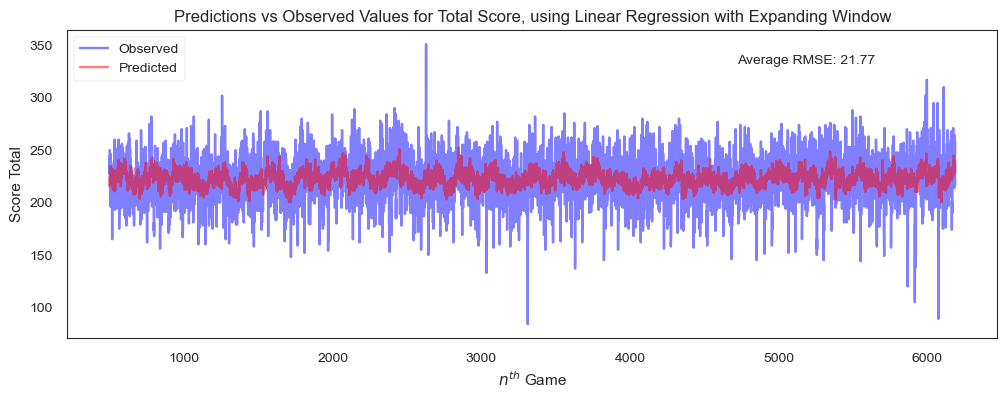

In [10]:
# observed values
observed_values = df[target_col][initial_train_size:]
# ensure that 'predictions' and 'observed_values' have the same length
predictions_aligned = model_outputs_lin[:len(observed_values)]

# plot
plt.figure(figsize=(12, 4))
plt.plot(observed_values.index, observed_values, label='Observed', color='blue', alpha=0.5)
plt.plot(observed_values.index, predictions_aligned, label='Predicted', color='red', alpha=0.5)
plt.title('Predictions vs Observed Values for Total Score, using Linear Regression with Expanding Window')
plt.xlabel(r'$n^{th}$ Game')
plt.ylabel('Score Total')
plt.text(x=0.72, y=0.92, s=f"Average RMSE: {reg_metrics_lin['average_rmse']:.2f}", transform=plt.gca().transAxes, 
         ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))
plt.legend();

<a name="1.2.-Rolling-Window"></a>
## 1.2. Rolling Window

[Return to top](#Baseline-Models)

In [11]:
# configuration for total points with rolling window

train_size = 500         # starting size of the training set
test_size = 1            # leave-one-out (LOO) cross-validation
df = pts_scaled_df       # data set to use
target_col = 'TOTAL_PTS' # target column name

# run model
model_outputs_lin, y_true_lin = utl.train_with_rolling_window(
    df=df,  
    train_size=train_size, 
    test_size=test_size,           
    target_col=target_col, 
    model=LinearRegression() 
)

Total time taken: 18.70 seconds


In [12]:
reg_metrics_lin = utl.calculate_metrics(y_true_lin, model_outputs_lin, model_type='linear')

Linear Regression Metrics:
- Average RMSE: 22.94


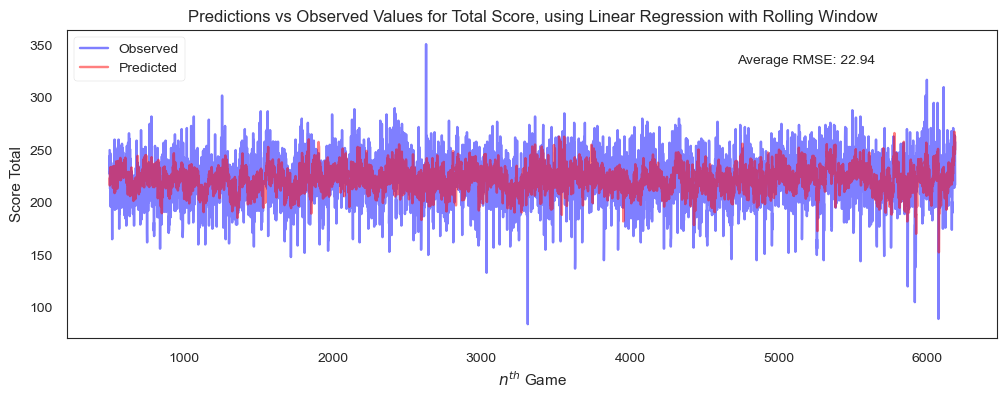

In [13]:
# observed values
observed_values = df[target_col][train_size:]
# ensure that 'predictions' and 'observed_values' have the same length
predictions_aligned = model_outputs_lin[:len(observed_values)]

# plot
plt.figure(figsize=(12, 4))
plt.plot(observed_values.index, observed_values, label='Observed', color='blue', alpha=0.5)
plt.plot(observed_values.index, predictions_aligned, label='Predicted', color='red', alpha=0.5)
plt.title('Predictions vs Observed Values for Total Score, using Linear Regression with Rolling Window')
plt.xlabel(r'$n^{th}$ Game')
plt.ylabel('Score Total')
plt.text(x=0.72, y=0.92, s=f"Average RMSE: {reg_metrics_lin['average_rmse']:.2f}", transform=plt.gca().transAxes, 
         ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))
plt.legend();

<a name="1.3.-Experiments-with-Different-Window-Sizes"></a>
## 1.3. Experiments with Different Window Sizes

[Return to top](#Baseline-Models)

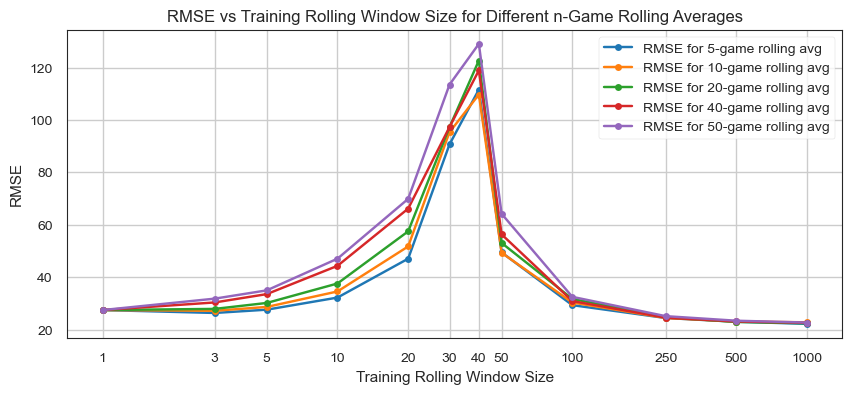

In [14]:
rmse_df = pd.read_csv('../data/processed/window_size_experiments_roll.csv')

# plot experiments with different window sizes
plt.figure(figsize=(10, 4))
plt.plot(rmse_df['train_size'], rmse_df['RMSE_5_games'], label='RMSE for 5-game rolling avg', marker='o', markersize=5)
plt.plot(rmse_df['train_size'], rmse_df['RMSE_10_games'], label='RMSE for 10-game rolling avg', marker='o', markersize=5)
plt.plot(rmse_df['train_size'], rmse_df['RMSE_20_games'], label='RMSE for 20-game rolling avg', marker='o', markersize=5)
# plt.plot(rmse_df['train_size'], rmse_df['RMSE_30_games'], label='RMSE for 30-game rolling avg', marker='o', markersize=5)
plt.plot(rmse_df['train_size'], rmse_df['RMSE_40_games'], label='RMSE for 40-game rolling avg', marker='o', markersize=5)
plt.plot(rmse_df['train_size'], rmse_df['RMSE_50_games'], label='RMSE for 50-game rolling avg', marker='o', markersize=5)
plt.title('RMSE vs Training Rolling Window Size for Different n-Game Rolling Averages')
plt.xlabel('Training Rolling Window Size')
plt.ylabel('RMSE')
# plt.xticks(rmse_df['Window Size'])
plt.xscale('log')
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.xticks(rmse_df['train_size'], labels=rmse_df['train_size'].astype(str))
plt.grid(True)
plt.legend()
plt.show()

<a name="2.-Target:-Difference-in-Points-(plus-/-minus)"></a>
# 2. Target: Difference in Points (plus / minus)

[Return to top](#Baseline-Models)

<a name="2.1.-Expanding-Window"></a>
## 2.1. Expanding Window

[Return to top](#Baseline-Models)

In [15]:
# configuration for points difference with expanding window

initial_train_size = 500  # starting size of the training set
test_size = 1             # leave-one-out (LOO) cross-validation
df = pm_scaled_df         # data set to use
target_col = 'PLUS_MINUS' # target column name

# run model
model_outputs_lin, y_true_lin = utl.train_with_expanding_window(
    df=df,  
    initial_train_size=initial_train_size, 
    test_size=test_size,           
    target_col=target_col, 
    model=LinearRegression() 
)

Total time taken: 32.56 seconds


In [16]:
reg_metrics_lin = utl.calculate_metrics(y_true_lin, model_outputs_lin, model_type='linear')

Linear Regression Metrics:
- Average RMSE: 14.33


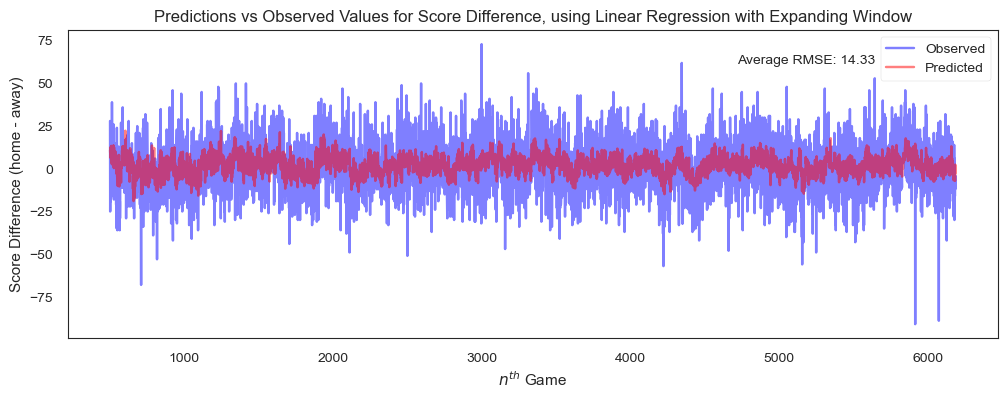

In [17]:
# observed values
observed_values = df[target_col][initial_train_size:]
# ensure that 'predictions' and 'observed_values' have the same length
predictions_aligned = model_outputs_lin[:len(observed_values)]

# plot
plt.figure(figsize=(12, 4))
plt.plot(observed_values.index, observed_values, label='Observed', color='blue', alpha=0.5)
plt.plot(observed_values.index, predictions_aligned, label='Predicted', color='red', alpha=0.5)
plt.title('Predictions vs Observed Values for Score Difference, using Linear Regression with Expanding Window')
plt.xlabel(r'$n^{th}$ Game')
plt.ylabel('Score Difference (home - away)')
plt.text(x=0.72, y=0.92, s=f"Average RMSE: {reg_metrics_lin['average_rmse']:.2f}", transform=plt.gca().transAxes, 
         ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))
plt.legend();

<a name="2.2.-Rolling-Window"></a>
## 2.2. Rolling Window

[Return to top](#Baseline-Models)

In [18]:
# configuration for points difference with rolling window

train_size = 500          # starting size of the training set
test_size = 1             # leave-one-out (LOO) cross-validation
df = pm_scaled_df         # data set to use
target_col = 'PLUS_MINUS' # target column name

# run model
model_outputs_lin, y_true_lin = utl.train_with_rolling_window(
    df=df,  
    train_size=train_size, 
    test_size=test_size,           
    target_col=target_col, 
    model=LinearRegression() 
)

Total time taken: 19.02 seconds


In [19]:
reg_metrics_lin = utl.calculate_metrics(y_true_lin, model_outputs_lin, model_type='linear')

Linear Regression Metrics:
- Average RMSE: 15.19


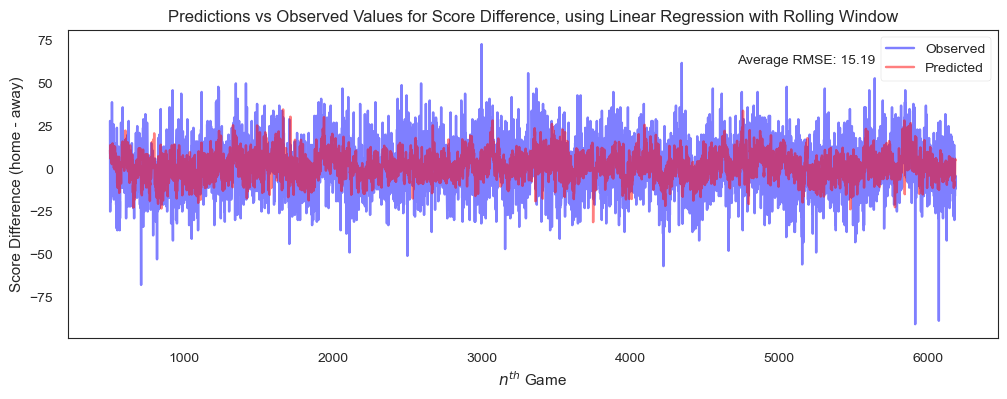

In [20]:
# observed values
observed_values = df[target_col][train_size:]
# ensure that 'predictions' and 'observed_values' have the same length
predictions_aligned = model_outputs_lin[:len(observed_values)]

# plot
plt.figure(figsize=(12, 4))
plt.plot(observed_values.index, observed_values, label='Observed', color='blue', alpha=0.5)
plt.plot(observed_values.index, predictions_aligned, label='Predicted', color='red', alpha=0.5)
plt.title('Predictions vs Observed Values for Score Difference, using Linear Regression with Rolling Window')
plt.xlabel(r'$n^{th}$ Game')
plt.ylabel('Score Difference (home - away)')
plt.text(x=0.72, y=0.92, s=f"Average RMSE: {reg_metrics_lin['average_rmse']:.2f}", transform=plt.gca().transAxes, 
         ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))
plt.legend();

<a name="3.-Target:-Game-Winner-(moneyline)"></a>
# 3. Target: Game Winner (moneyline)

[Return to top](#Baseline-Models)

<a name="3.1.-Expanding-Window"></a>
## 3.1. Expanding Window

[Return to top](#Baseline-Models)

In [21]:
# configuration for game winner with expanding window

initial_train_size = 500   # starting size of the training set
test_size = 1              # leave-one-out (LOO) cross-validation
df = res_scaled_df         # data set to use
target_col = 'GAME_RESULT' # target column name

# run model
model_outputs_log, y_true_log = utl.train_with_expanding_window(
    df=df, 
    initial_train_size=initial_train_size, 
    test_size=test_size, 
    target_col=target_col, 
    model=LogisticRegression(max_iter=1000, solver='liblinear'),
    ensure_diversity=True # ensure class diversity in training for logistic regression
)  

Total time taken: 54.11 seconds


In [22]:
reg_metrics_log = utl.calculate_metrics(y_true_log, model_outputs_log, model_type='logistic')

Logistic Regression Metrics:
- Average Accuracy: 0.60
- Overall AUC: 0.64
- Average F1 Score: 0.67


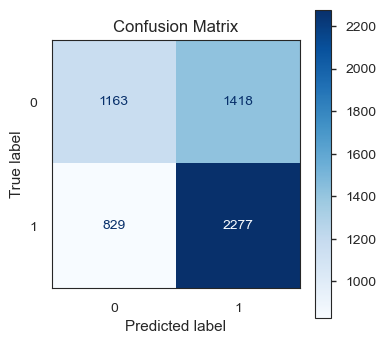

In [23]:
# calculate confusion matrix
cm = confusion_matrix(y_true_log, reg_metrics_log['pred_labels'])

# plot
fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix');

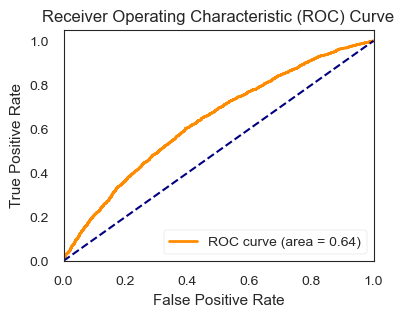

In [24]:
# calculate FPR (False Positive Rate), TPR (True Positive Rate), and threshold values
fpr, tpr, thresholds = roc_curve(y_true_log, reg_metrics_log['prob_predictions'])

# calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right");

<a name="3.2.-Rolling-Window"></a>
## 3.2. Rolling Window

[Return to top](#Baseline-Models)

In [25]:
# configuration for game winner with rolling window

train_size = 500           # starting size of the training set
test_size = 1              # leave-one-out (LOO) cross-validation
df = res_scaled_df         # data set to use
target_col = 'GAME_RESULT' # target column name

# run model
model_outputs_log, y_true_log = utl.train_with_rolling_window(
    df=df,  
    train_size=train_size, 
    test_size=test_size,           
    target_col=target_col, 
    model=LogisticRegression(max_iter=1000, solver='liblinear'),
    ensure_diversity=True
)

Total time taken: 12.33 seconds


In [26]:
reg_metrics_log = utl.calculate_metrics(y_true_log, model_outputs_log, model_type='logistic')

Logistic Regression Metrics:
- Average Accuracy: 0.59
- Overall AUC: 0.62
- Average F1 Score: 0.65


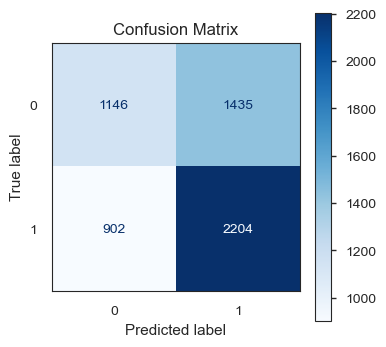

In [27]:
# calculate confusion matrix
cm = confusion_matrix(y_true_log, reg_metrics_log['pred_labels'])

# plot
fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix');

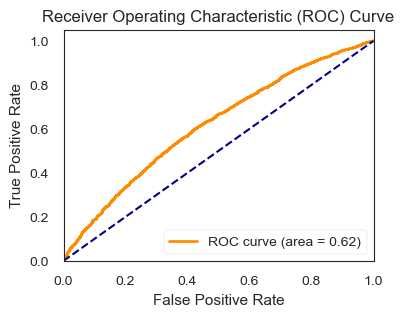

In [28]:
# calculate FPR (False Positive Rate), TPR (True Positive Rate), and threshold values
fpr, tpr, thresholds = roc_curve(y_true_log, reg_metrics_log['prob_predictions'])

# calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right");